In [140]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

 对齐直接用的网上的代码

In [141]:
def align_images(images):

    if not isinstance(images, list) or len(images) < 2:
        print("Input has to be a list of at least two images")
        return None

    size = images[0].shape
    for i in range(len(images)):
        if not images[i].shape == size:
            print("Input images have to be of the same size")
            return None

    # Convert images to grayscale
    gray_images = []
    for image in images:
        gray_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

    model_image = gray_images[0]

    # Find size of images
    sz = model_image.shape

    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 5000

    # Specify the threshold of the increment in the correlation coefficient between two iterations
    termination_eps = 1e-10

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations, termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    aligned_images = [images[0]]
    for i in range(1, len(images)):
        (cc, warp_matrix) = cv2.findTransformECC(model_image, gray_images[i], warp_matrix, warp_mode, criteria, inputMask=None, gaussFiltSize=3)

        if warp_mode == cv2.MOTION_HOMOGRAPHY :
            # Use warpPerspective for Homography
            aligned_image = cv2.warpPerspective (images[i], warp_matrix, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        else:
            # Use warpAffine for Translation, Euclidean and Affine
            aligned_image = cv2.warpAffine(images[i], warp_matrix, (sz[1], sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        aligned_images.append(aligned_image)

    return aligned_images

In [272]:
def compute_weights(images):
    (w_c, w_s, w_e) = (1, 1, 1)
    
    weights = []
    weight_sum = np.zeros(images[0].shape[:2], dtype=np.float32)
    for image in images:
        image = np.float32(image)/255
        weight = np.zeros(image.shape[:2], dtype = np.float32)
        
        # contrast
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_32F)
        contrast_weight = np.absolute(laplacian) ** w_c + 1

        # saturation
        saturation_weight = image.std(axis=2, dtype=np.float32) + 1
        
        # well-exposedness
        sigma2 = 0.2
        exposedness_weight = np.prod(np.exp(-((image - 0.5)**2)/(2*sigma2)), axis=2, dtype=np.float32) ** w_e + 1
        
        weight = contrast_weight * saturation_weight * exposedness_weight
        weight_sum += weight
        weights.append(weight)
        
    # normalization
    nonzero = weight_sum > 0
    for i in range(len(weights)):
        weights[i][nonzero] /= weight_sum[nonzero]
        weights[i] = np.uint8(weights[i]*255)
        
    return weights

In [155]:
def get_gaussian_pyramid(image, depth):
    G = image.copy()
    gpA = [G]
    for i in range(depth):
        G = cv.pyrDown(G)
        gpA.append(G)
    return gpA

In [246]:
def get_laplacian_pyramid(image, depth):
    gpA = get_gaussion_pyramid(image, depth)
    lpA = [gpA[depth-1]]
    for i in range(depth-1,0,-1):
        GE = cv.pyrUp(gpA[i])
        L = cv.subtract(gpA[i-1],GE)
        lpA = [L] + lpA
    return lpA

In [145]:
def pyramid_collapse(pyramid):
    depth = len(pyramid)
    collapsed = pyramid[depth-1]
    for i in range(depth-2, -1, -1):
        collapsed = cv.add(cv.pyrUp(collapsed), pyramid[i])
    return collapsed

In [ ]:
# def exposure_fusion(images, depth):

    # compute weights
    weights = compute_weights(images)

    #compute pyramids
    lps = []
    gps = []
    for (image, weight) in zip(images, weights):
        lps.append(get_laplacian_pyramid(image, depth))
        gps.append(get_gaussian_pyramid(weight, depth))

    # combine pyramids with weights
    LS = []
    for l in range(depth):
        ls = np.zeros(lps[0][l].shape, dtype=np.uint8)
        for k in range(len(images)):
            lp = lps[k][l]
            gps_float = np.float32(gps[k][l])/255
            gp = np.dstack((gps_float, gps_float, gps_float))
            lp_gp = cv2.multiply(lp, gp, dtype=cv2.CV_8UC3)
            ls = cv2.add(ls, lp_gp)
            
        LS.append(ls)

    # collapse pyramid
    fusion = pyramid_collapse(LS)
    return fusion

In [307]:
img1 = cv2.imread('samples/peyrou_mean.jpg')
img2 = cv2.imread('samples/peyrou_under.jpg')
img3 = cv2.imread('samples/peyrou_over.jpg')

images = [img1, img2, img3]

aligned_images = align_images(images)


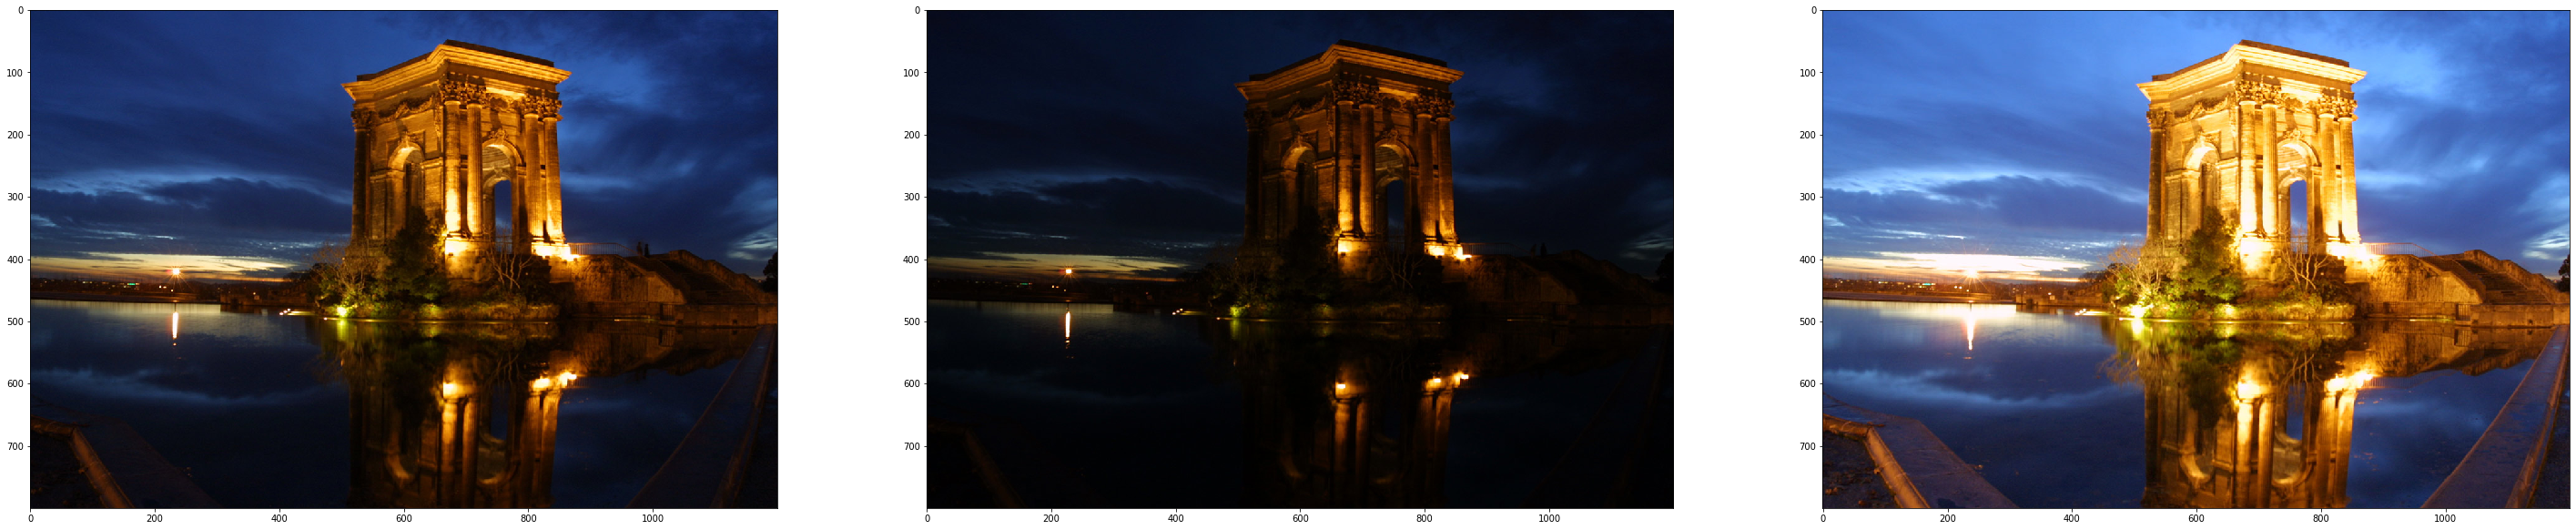

In [315]:
fig=plt.figure(figsize=(50, 50))
columns = 3
rows = 1
fig.add_subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

## pyramid

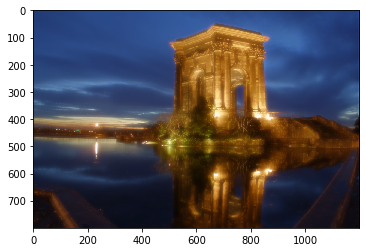

In [317]:
fusion = exposure_fusion(aligned_images, depth=4)
fusion2 = cv2.cvtColor(fusion, cv2.COLOR_BGR2RGB)
plt.imshow(fusion2)

# cv2.imwrite('samples/peyrou_fusion.jpg', fusion)

## naive

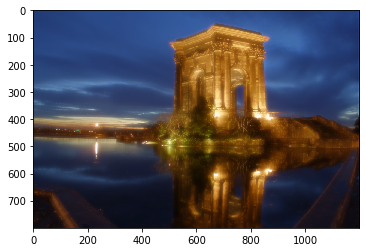

In [305]:
weights = compute_weights(images)
weights_f = np.float32(weights)/255
res = np.zeros(images[0].shape, dtype = np.float32)
for (image, weight) in zip(images, weights_f):
    res += np.float32(image) * np.dstack((weight, weight, weight))
res = cv2.cvtColor(fusion, cv2.COLOR_BGR2RGB)
plt.imshow(np.uint8(res))